<a href="https://colab.research.google.com/github/thedynasty23/Shopping-Spectrum/blob/main/Shopper_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialization

In [51]:
pip install streamlit

In [52]:
# Importing Libraries
# Core Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering Algorithms and Evaluation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Recommendation System
from sklearn.metrics.pairwise import cosine_similarity

# App Deployment
import streamlit as st

# Miscellaneous
import warnings

# Optional: For 3D Plots and advanced visuals
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3D scatter plot)

In [53]:
df = pd.read_csv("/content/drive/MyDrive/online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Exploring Dataset

In [54]:
# Checking the number of rows and columns of the data
df.shape

(541909, 8)

In [55]:
# Number of unique values in each colums
for col in df.columns:
  num_unique = df[col].nunique()
  print(f"{col} : {num_unique}")

InvoiceNo : 25900
StockCode : 4070
Description : 4223
Quantity : 722
InvoiceDate : 23260
UnitPrice : 1630
CustomerID : 4372
Country : 38


In [56]:
# Info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [57]:
# Describing the dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# 3. Data Preprocessing

**Missing values**

In [58]:
# Null values per column
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


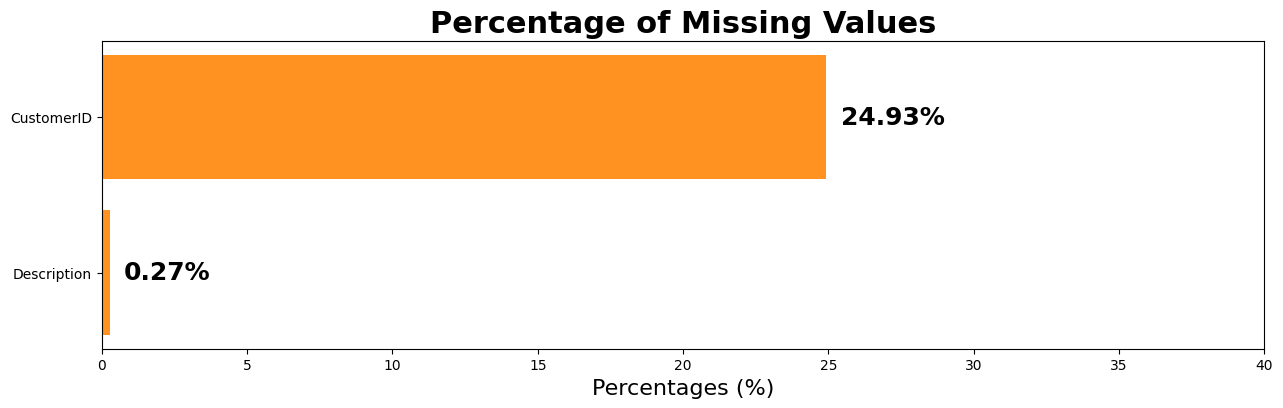

In [59]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff9220')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

**Duplicate Values**

In [60]:
# Number of Duplicated rows
df.duplicated().sum()

np.int64(5268)

In [61]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2022-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2022-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2022-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2022-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2022-12-01 11:45:00,2.10,17908.0,United Kingdom


**Unusual Records**
- Missing CustomerID
- Cancelled invoices
- Negative or zero Quantity
- Negative or zero UnitPrice
- Duplicate rows

In [62]:
# Rows with missing CustomerID
missing_customerid = df[df['CustomerID'].isnull()]
print("Rows with missing CustomerID:")
print(missing_customerid)

Rows with missing CustomerID:
       InvoiceNo StockCode                      Description  Quantity  \
622       536414     22139                              NaN        56   
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

                InvoiceDate  UnitPrice  CustomerID         Country  
622     2022-12-01 11:52

In [63]:
# Cancelled invoices (InvoiceNo starting with 'C')
cancelled_invoices = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print("\nCancelled invoices (InvoiceNo starts with 'C'):")
print(cancelled_invoices)


Cancelled invoices (InvoiceNo starts with 'C'):
       InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate  UnitPrice  CustomerID         Cou

In [64]:
# Rows with negative or zero Quantity
neg_zero_quantity = df[df['Quantity'] <= 0]
print("\nRows with negative or zero Quantity:")
print(neg_zero_quantity)


Rows with negative or zero Quantity:
       InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate  UnitPrice  CustomerID         Country  
141 

In [65]:
# Rows with negative or zero UnitPrice
neg_zero_unitprice = df[df['UnitPrice'] <= 0]
print("\nRows with negative or zero UnitPrice:")
print(neg_zero_unitprice)


Rows with negative or zero UnitPrice:
       InvoiceNo StockCode                   Description  Quantity  \
622       536414     22139                           NaN        56   
1970      536545     21134                           NaN         1   
1971      536546     22145                           NaN         1   
1972      536547     37509                           NaN         1   
1987      536549    85226A                           NaN         1   
...          ...       ...                           ...       ...   
536981    581234     72817                           NaN        27   
538504    581406    46000M  POLYESTER FILLER PAD 45x45cm       240   
538505    581406    46000S  POLYESTER FILLER PAD 40x40cm       300   
538554    581408     85175                           NaN        20   
538919    581422     23169                       smashed      -235   

                InvoiceDate  UnitPrice  CustomerID         Country  
622     2022-12-01 11:52:00        0.0         NaN 

In [66]:
# Duplicate rows
duplicates = df[df.duplicated()]
print("\nDuplicate rows:")
print(duplicates)


Duplicate rows:
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

                InvoiceDate  UnitPrice  CustomerID         Country  
517     2022-

In [67]:
# Counts of these unusual records
print("\nSummary of unusual records counts")
print("-"*50)
print(f"Missing CustomerID : {missing_customerid.shape[0]}")
print(f"Cancelled invoices : {cancelled_invoices.shape[0]}")
print(f"Negative or zero Quantity : {neg_zero_quantity.shape[0]}")
print(f"Negative or zero UnitPrice : {neg_zero_unitprice.shape[0]}")
print(f"Duplicate rows : {duplicates.shape[0]}")
print("-"*50)


Summary of unusual records counts
--------------------------------------------------
Missing CustomerID : 135080
Cancelled invoices : 9288
Negative or zero Quantity : 10624
Negative or zero UnitPrice : 2517
Duplicate rows : 5268
--------------------------------------------------


**Handling Missing Values**

In [68]:
# Drop rows where 'CustomerID' is missing (NaN)
df_clean = df.dropna(subset=['CustomerID'])

# Optional: reset index after dropping rows
df_clean.reset_index(drop=True, inplace=True)

# Verify removal
print(f"Rows after removing missing CustomerID: {df_clean.shape[0]} (removed {df.shape[0] - df_clean.shape[0]} rows)")

Rows after removing missing CustomerID: 406829 (removed 135080 rows)


**Excluding Cancelled Invoices**

In [69]:
# Keep only rows where 'InvoiceNo' does NOT start with 'C'
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Reset index after filtering
df_clean.reset_index(drop=True, inplace=True)

# Verify removal
cancelled_count = df.shape[0] - df_clean.shape[0] - (df.shape[0] - df.dropna(subset=['CustomerID']).shape[0]) # Approximate number removed here
print(f"Rows after excluding cancelled invoices: {df_clean.shape[0]}")

Rows after excluding cancelled invoices: 397924


**Handling Zero or Negative UnitPrice & Quantity**

In [70]:
# Keep only rows where Quantity and UnitPrice are positive
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Reset index again after filtering
df_clean.reset_index(drop=True, inplace=True)

# Verify removal
print(f"Final number of rows after removing negative or zero quantities and prices: {df_clean.shape[0]}")

Final number of rows after removing negative or zero quantities and prices: 397884


In [71]:
# Number of rows and columns after Data Cleaning
df_clean.shape

(397884, 8)

# 4. Exploratory Data Analysis

#### 1. Transaction Volume By Country

In [72]:
# Creating DataFrame for Number of Transactions per Country
country_counts = df_clean['Country'].value_counts()
country_counts.head(10)

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484
Netherlands,2359
Belgium,2031
Switzerland,1841
Portugal,1462


In [73]:
# Number of Country
country_counts.shape

(37,)

/tmp/ipython-input-1146411848.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette='bright')


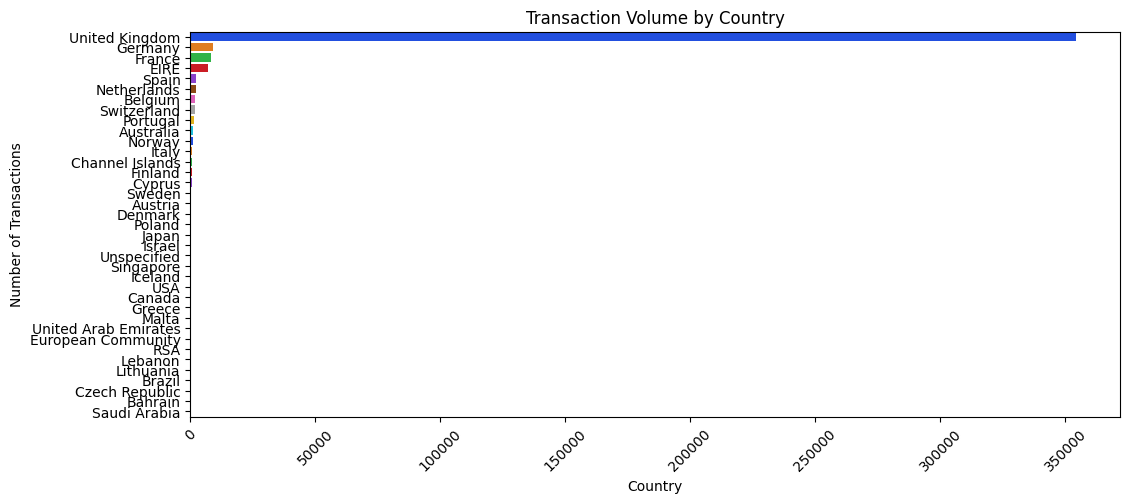

In [74]:
# Transaction Volume by Country
plt.figure(figsize=(12,5))
sns.barplot(x=country_counts.values, y=country_counts.index, palette='bright')
plt.title('Transaction Volume by Country')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-1671642923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values[:10], y=country_counts[:10].index, palette='bright')


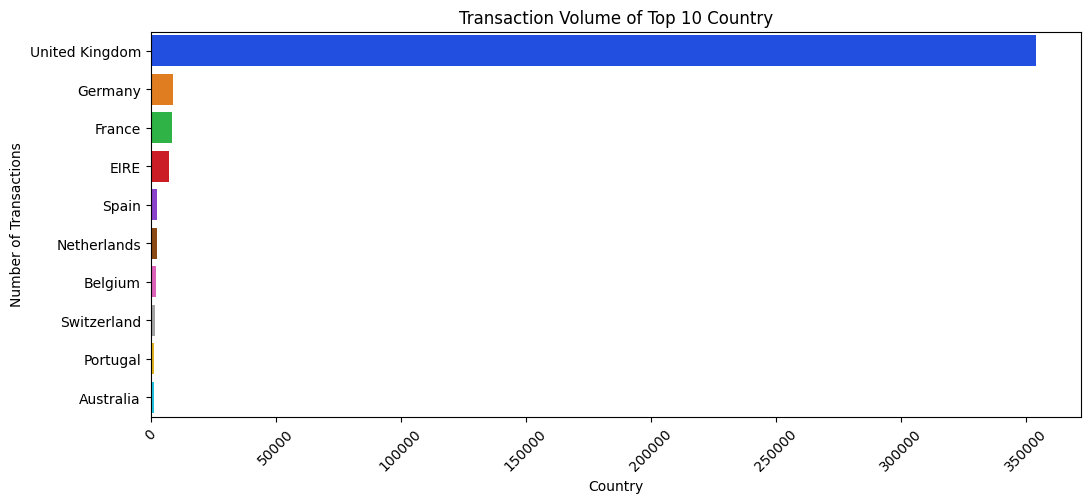

In [75]:
# Transaction Volume of Top 10 Country
plt.figure(figsize=(12,5))
sns.barplot(x=country_counts.values[:10], y=country_counts[:10].index, palette='bright')
plt.title('Transaction Volume of Top 10 Country')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

#### 2. Top Selling Products

In [76]:
# Creating Dataframe for Top 10 Products and its count
top_products = df_clean['Description'].value_counts()[:10]
top_products.head(10)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2028
REGENCY CAKESTAND 3 TIER,1723
JUMBO BAG RED RETROSPOT,1618
ASSORTED COLOUR BIRD ORNAMENT,1408
PARTY BUNTING,1396
LUNCH BAG RED RETROSPOT,1316
SET OF 3 CAKE TINS PANTRY DESIGN,1159
LUNCH BAG BLACK SKULL.,1105
POSTAGE,1099


/tmp/ipython-input-1998359060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.index, x=top_products.values, palette='bright')


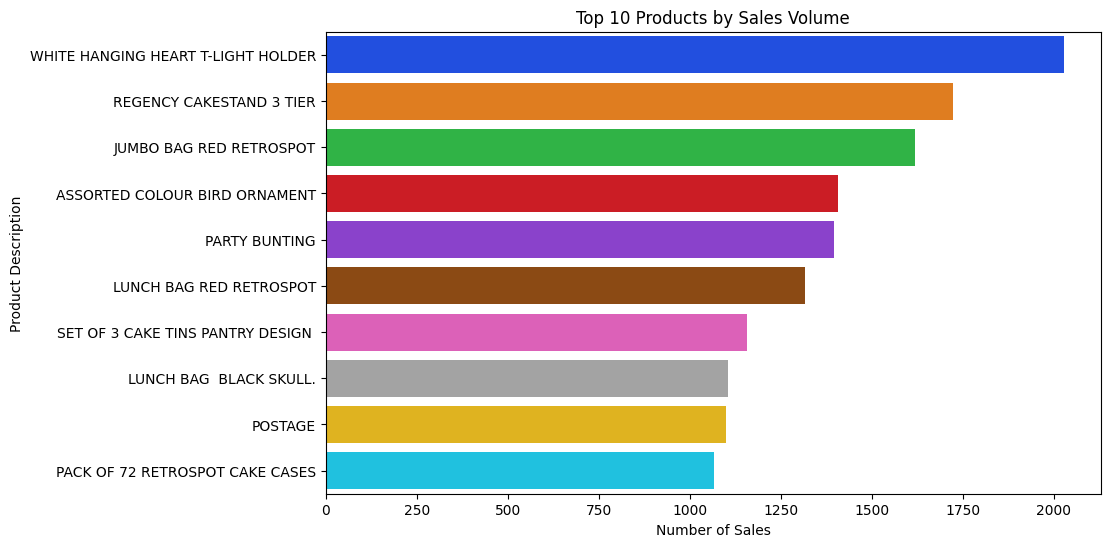

In [77]:
# Plotting Horizontal Plot
plt.figure(figsize=(10,6))
sns.barplot(y=top_products.index, x=top_products.values, palette='bright')
plt.title('Top 10 Products by Sales Volume')
plt.xlabel('Number of Sales')
plt.ylabel('Product Description')
plt.show()

#### 3. Purchase Trends Over Time

In [78]:
# Ensure InvoiceDate is datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [79]:
# Creating dataframe for Transactions per Month
monthly_transactions = df_clean.set_index('InvoiceDate').resample('M').size()
monthly_transactions.head(10)

/tmp/ipython-input-2334795737.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_transactions = df_clean.set_index('InvoiceDate').resample('M').size()


,0
InvoiceDate,
2022-12-31,26157
2023-01-31,21229
2023-02-28,19927
2023-03-31,27175
2023-04-30,22642
2023-05-31,28320
2023-06-30,27185
2023-07-31,26825
2023-08-31,27007


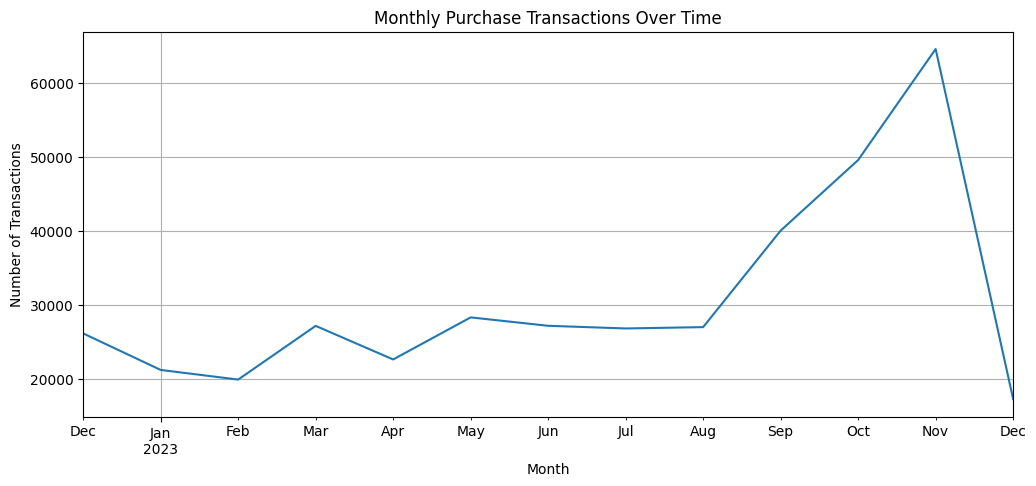

In [80]:
# Plotting Line Graph
plt.figure(figsize=(12,5))
monthly_transactions.plot()
plt.title('Monthly Purchase Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

#### 4. Monetary Distribution

In [81]:
# Ensure 'TotalPrice' column exists: Quantity * UnitPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**Monetary Distribution Per Transaction**

In [82]:
# Distribution of money spent per transaction
transaction_totals = df_clean.groupby('InvoiceNo')['TotalPrice'].sum()
transaction_totals.head()

,TotalPrice
InvoiceNo,
536365,139.12
536366,22.20
536367,278.73
536368,70.05
536369,17.85


In [83]:
# Capping outliers for better visualization (90th percentile)
transaction_totals = df_clean.groupby('InvoiceNo')['TotalPrice'].sum()
customer_totals = df_clean.groupby('CustomerID')['TotalPrice'].sum()
trans_cap = transaction_totals[transaction_totals < transaction_totals.quantile(0.99)]
cust_cap = customer_totals[customer_totals < customer_totals.quantile(0.99)]

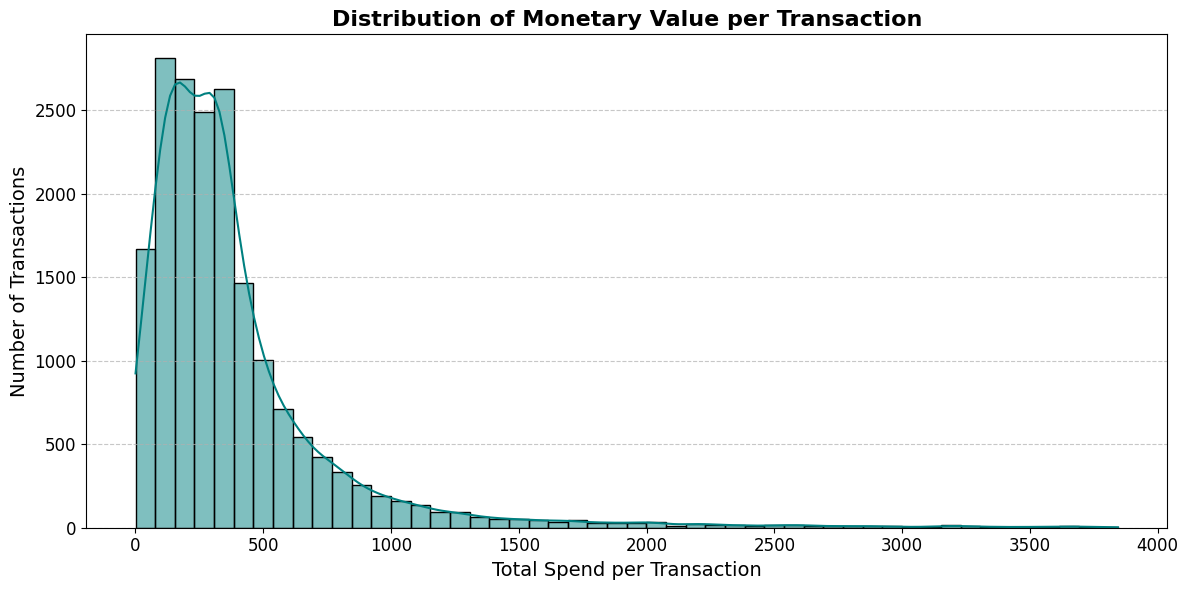

In [84]:
# Improved Distribution: Per Transaction
plt.figure(figsize=(12,6))
sns.histplot(trans_cap, bins=50, kde=True, color='teal')
plt.title('Distribution of Monetary Value per Transaction', fontsize=16, weight='bold')
plt.xlabel('Total Spend per Transaction', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

**Monetary Distribution Per Customer**

In [85]:
# Distribution of money spent per customer
customer_totals = df_clean.groupby('CustomerID')['TotalPrice'].sum()

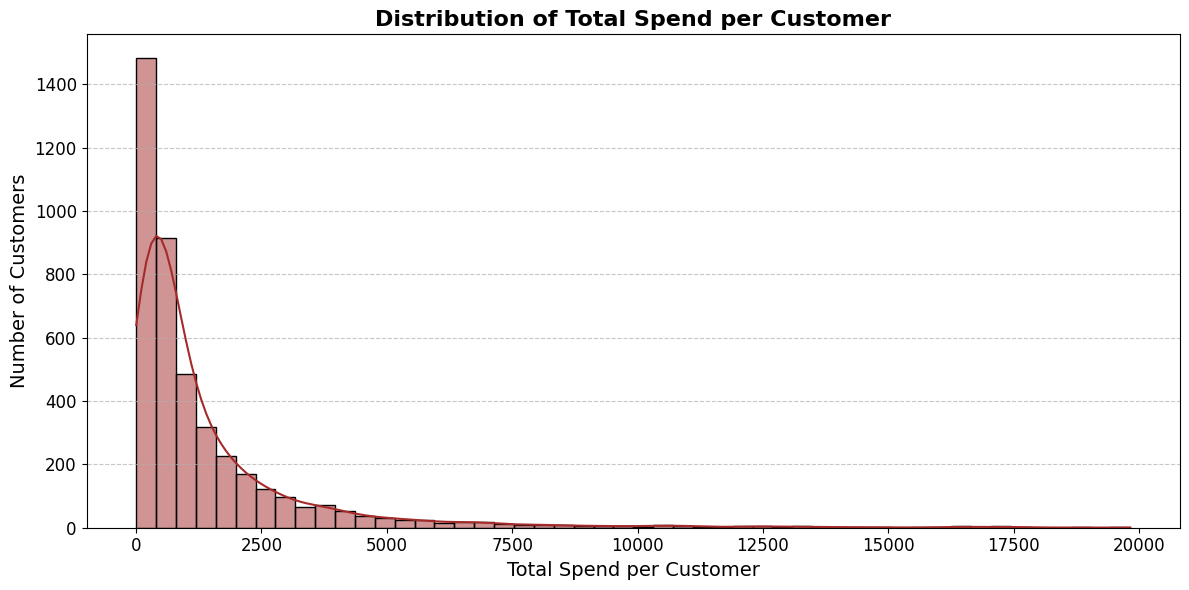

In [86]:
# Improved Distribution: Per Customer
plt.figure(figsize=(12,6))
sns.histplot(cust_cap, bins=50, kde=True, color='brown')
plt.title('Distribution of Total Spend per Customer', fontsize=16, weight='bold')
plt.xlabel('Total Spend per Customer', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

#### 5. RFM Distributions

**Recency**
- *Days Since Last Purchase* : This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.


In [87]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


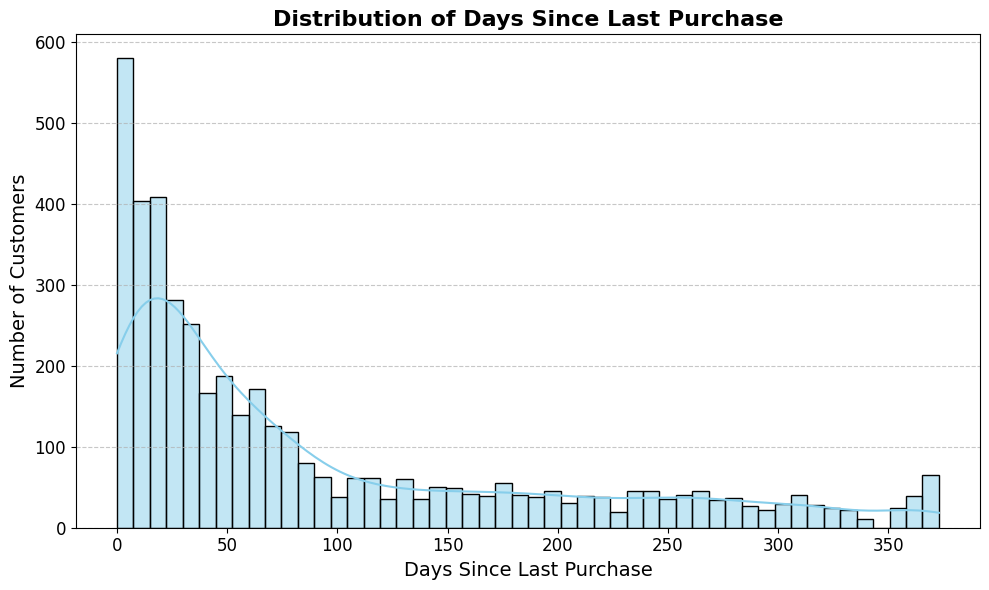

In [88]:
# Plotting Graph for Distribution of Days Since Last Purchase
plt.figure(figsize=(10, 6))
sns.histplot(customer_data['Days_Since_Last_Purchase'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Days Since Last Purchase', fontsize=16, weight='bold')
plt.xlabel('Days Since Last Purchase', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

**Frequency**
- *Total Transactions* : This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

- *Total Products Purchased* : This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [89]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2341
3,12349.0,18,1,631
4,12350.0,310,1,197


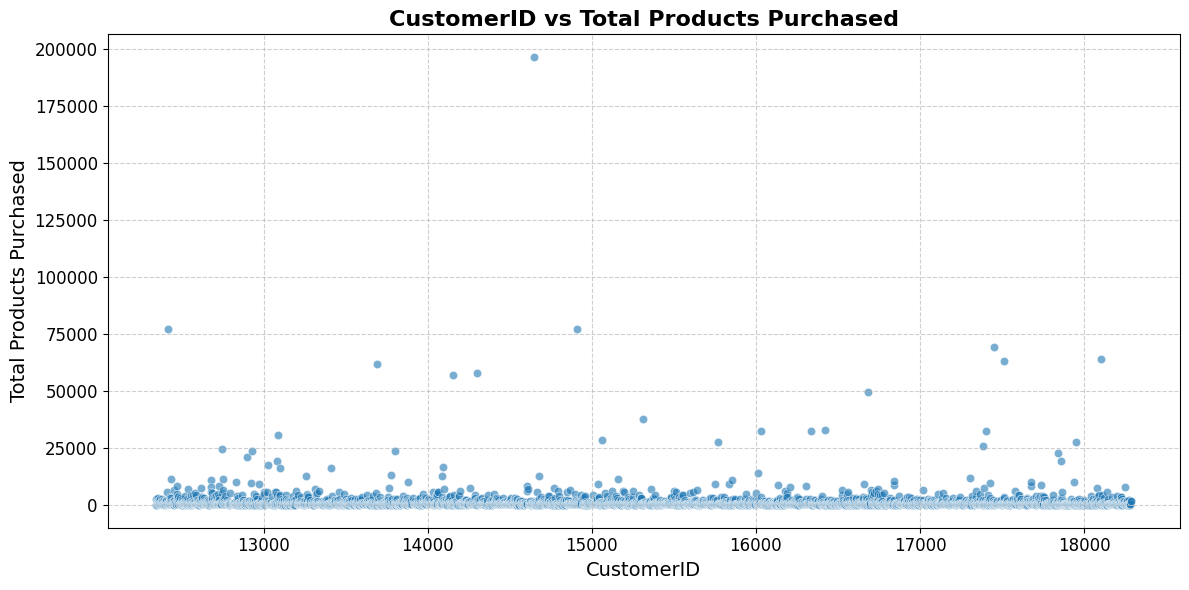

In [90]:
# CustomerID vs Total Products Purchased
plt.figure(figsize=(12, 6))
sns.scatterplot(data=customer_data, x='CustomerID', y='Total_Products_Purchased', alpha=0.6)
plt.title('CustomerID vs Total Products Purchased', fontsize=16, weight='bold')
plt.xlabel('CustomerID', fontsize=14)
plt.ylabel('Total Products Purchased', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

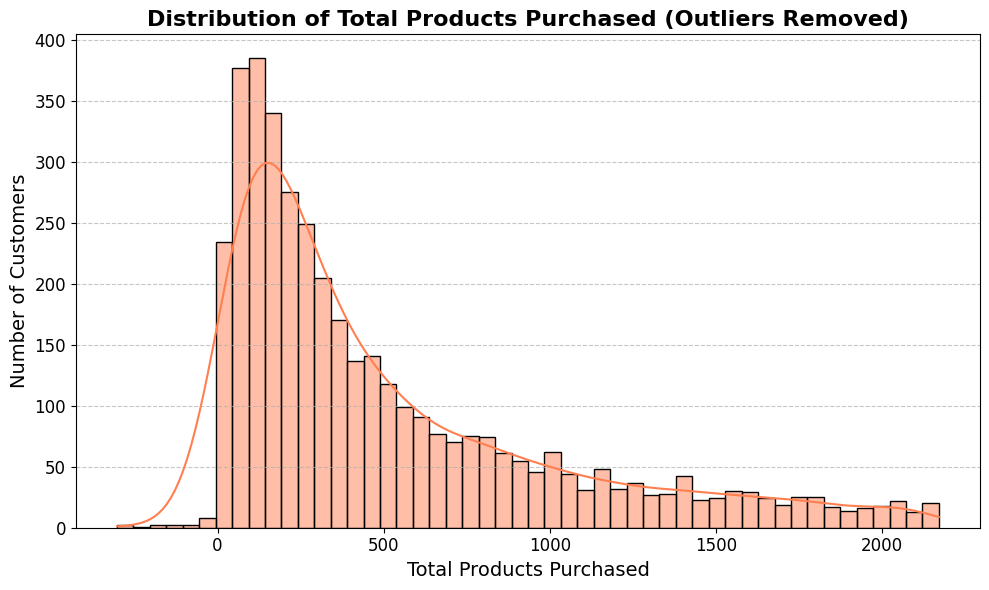

In [91]:
# Calculate IQR for Total_Products_Purchased
Q1 = customer_data['Total_Products_Purchased'].quantile(0.25)
Q3 = customer_data['Total_Products_Purchased'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
customer_data_filtered = customer_data[(customer_data['Total_Products_Purchased'] >= lower_bound) & (customer_data['Total_Products_Purchased'] <= upper_bound)].copy()

# Plot the distribution after outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(customer_data_filtered['Total_Products_Purchased'], bins=50, kde=True, color='coral')
plt.title('Distribution of Total Products Purchased (Outliers Removed)', fontsize=16, weight='bold')
plt.xlabel('Total Products Purchased', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

**Monetary**
- *Total Spend* : This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

- *Average Transaction Value* : This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [92]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2341,1797.24,449.310000
3,12349.0,18,1,631,1757.55,1757.550000
4,12350.0,310,1,197,334.40,334.400000


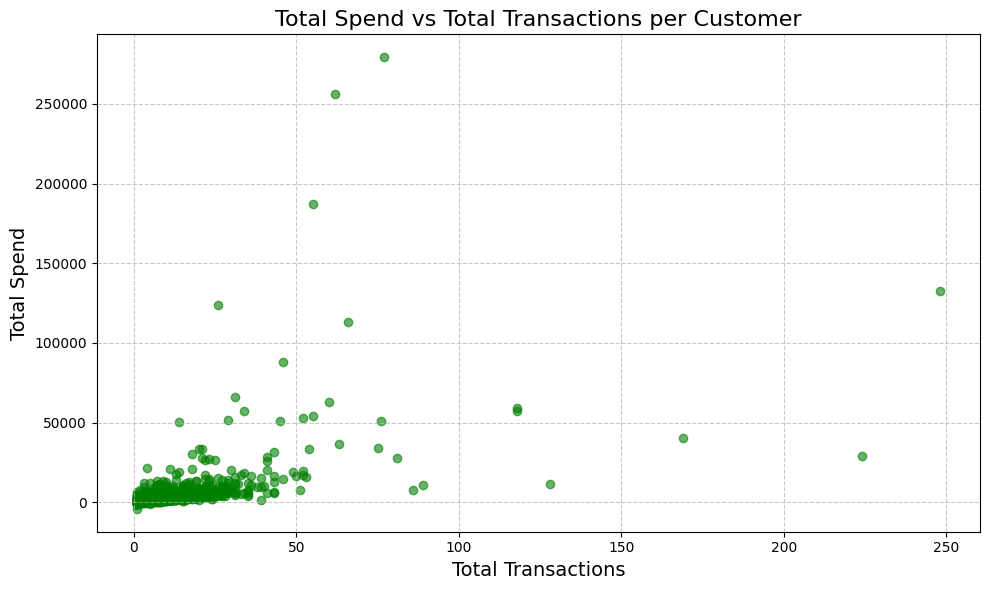

In [93]:
# Total Spend vs Total Transactions per Customer
plt.figure(figsize=(10,6))
plt.scatter(customer_data['Total_Transactions'], customer_data['Total_Spend'], alpha=0.6, c='green')
plt.title('Total Spend vs Total Transactions per Customer', fontsize=16)
plt.xlabel('Total Transactions', fontsize=14)
plt.ylabel('Total Spend', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 6. Product Diversity


- *Unique Products Purchased* : This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [94]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2341,1797.24,449.310000,22
3,12349.0,18,1,631,1757.55,1757.550000,73
4,12350.0,310,1,197,334.40,334.400000,17


#### 7. Behavioural Insights


- Average Days Between Purchases : This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

- Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

- Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

In [95]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

/tmp/ipython-input-2052236717.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14
2,12348.0,75,4,2341,1797.24,449.310000,22,9.433333,4,19
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,1,9
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,3,16


#### 8. Seasonality and Trends


- *Monthly_Spending_Mean* : This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

- *Monthly_Spending_Std* : This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

- *Spending_Trend* : This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [96]:
from scipy.stats import linregress

# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

/tmp/ipython-input-1147560530.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14,615.714286,341.070789,4.486071
2,12348.0,75,4,2341,1797.24,449.310000,22,9.433333,4,19,449.310000,301.159918,-160.884000
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,1,9,1757.550000,0.000000,0.000000
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,3,16,334.400000,0.000000,0.000000


**Monthly Transactions**

In [126]:
# Ensure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a 'YearMonth' column for grouping by month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Count the number of transactions per month
transactions_per_month = df.groupby('YearMonth').size().reset_index(name='TransactionCount')
# Convert 'YearMonth' back to datetime for plotting
transactions_per_month['YearMonth'] = transactions_per_month['YearMonth'].dt.to_timestamp()

# Adding month_name as index
df['MonthName'] = df['InvoiceDate'].dt.strftime('%B')
transactions_per_month = df.groupby('MonthName').size().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]).reset_index(name='TransactionCount')

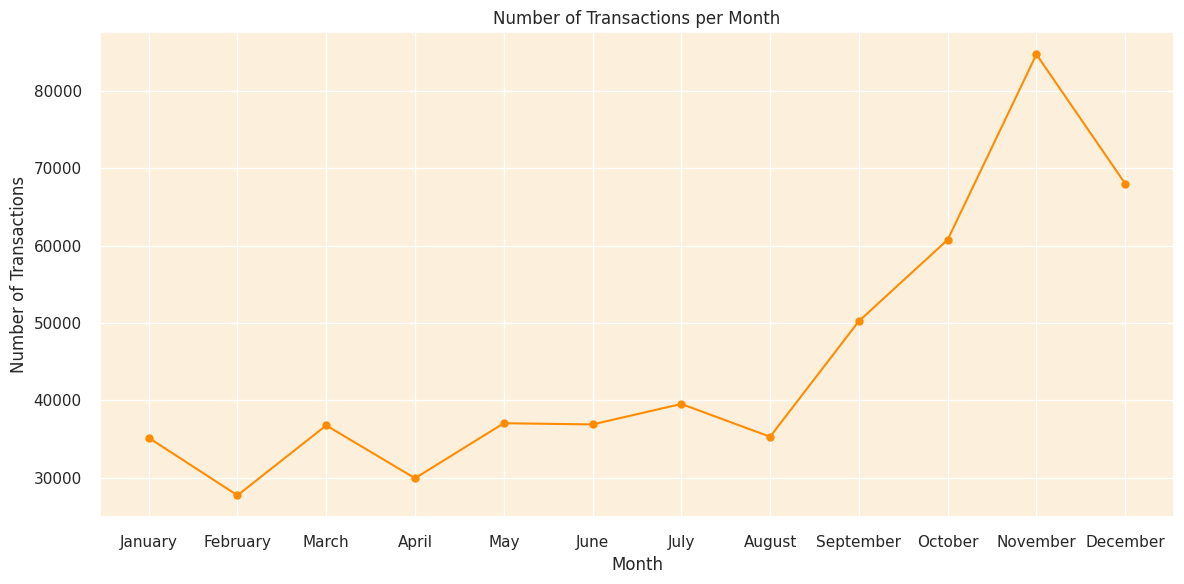

In [127]:
# Plotting Transactions per month
plt.figure(figsize=(12,6))
plt.plot(transactions_per_month['MonthName'], transactions_per_month['TransactionCount'], marker='o')
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

**Daily Transactions**

In [131]:
# Ensure 'InvoiceDate' is datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a column with the day name, e.g. Monday, Tuesday, etc.
df['DayName'] = df['InvoiceDate'].dt.day_name()

# To preserve weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayName'] = pd.Categorical(df['DayName'], categories=weekday_order, ordered=True)

# Count transactions per day of week
transactions_per_day = df.groupby('DayName').size().reindex(weekday_order).reset_index(name='TransactionCount')

/tmp/ipython-input-69161690.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



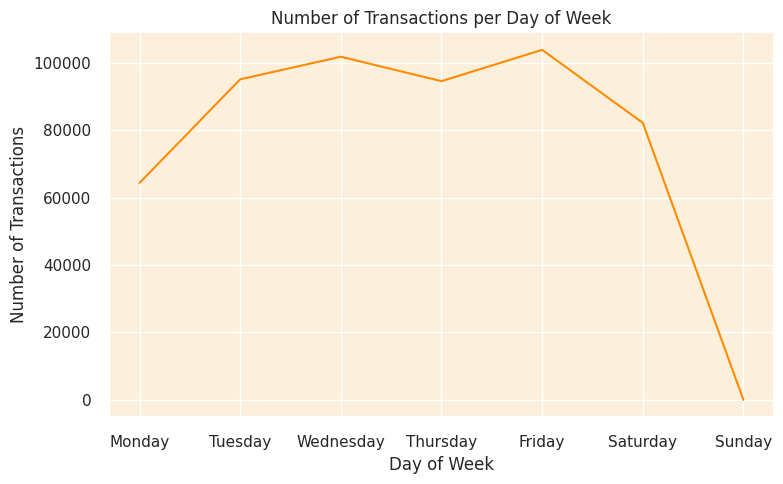

In [139]:
# Plotting Daily Transactions
plt.figure(figsize=(8,5))
plt.plot(transactions_per_day['DayName'],transactions_per_day['TransactionCount'])
plt.title('Number of Transactions per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

**Transactions Hourly**

In [138]:
# Ensure your datetime column is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract hour
df['Hour'] = df['InvoiceDate'].dt.hour

# Count transactions per hour
transactions_per_hour = df.groupby('Hour').size().reset_index(name='TransactionCount')

# Prepare hour labels like "0:00", "1:00", ..., "23:00"
hour_labels = [f"{h}:00" for h in transactions_per_hour['Hour']]

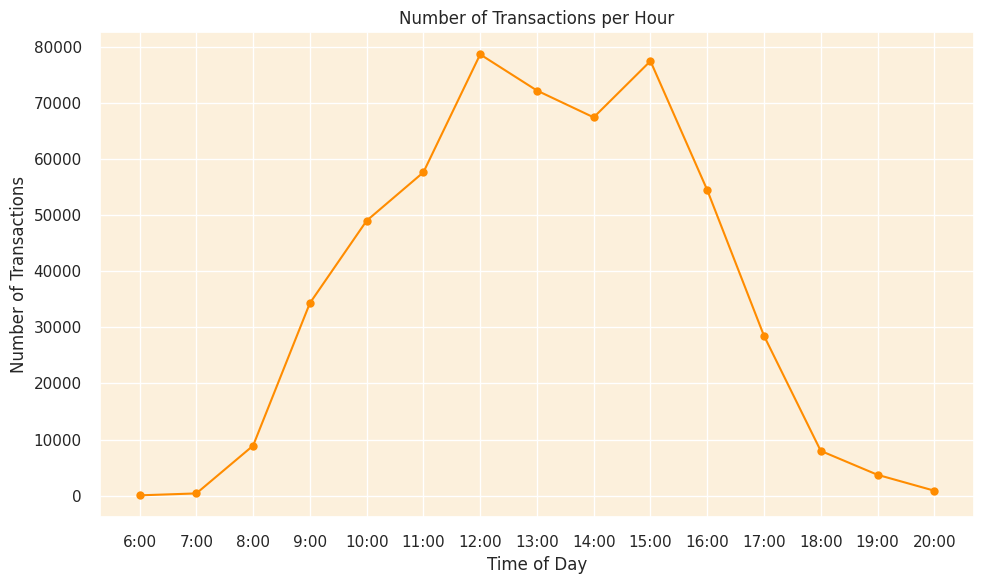

In [140]:
# Hourly Transactions
plt.figure(figsize=(10,6))
plt.plot(hour_labels, transactions_per_hour['TransactionCount'], marker='o')
plt.title('Number of Transactions per Hour')
plt.xlabel('Time of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

#### 9. Outliers Detection and Treatment

**Box Plot for Outliers Detection**

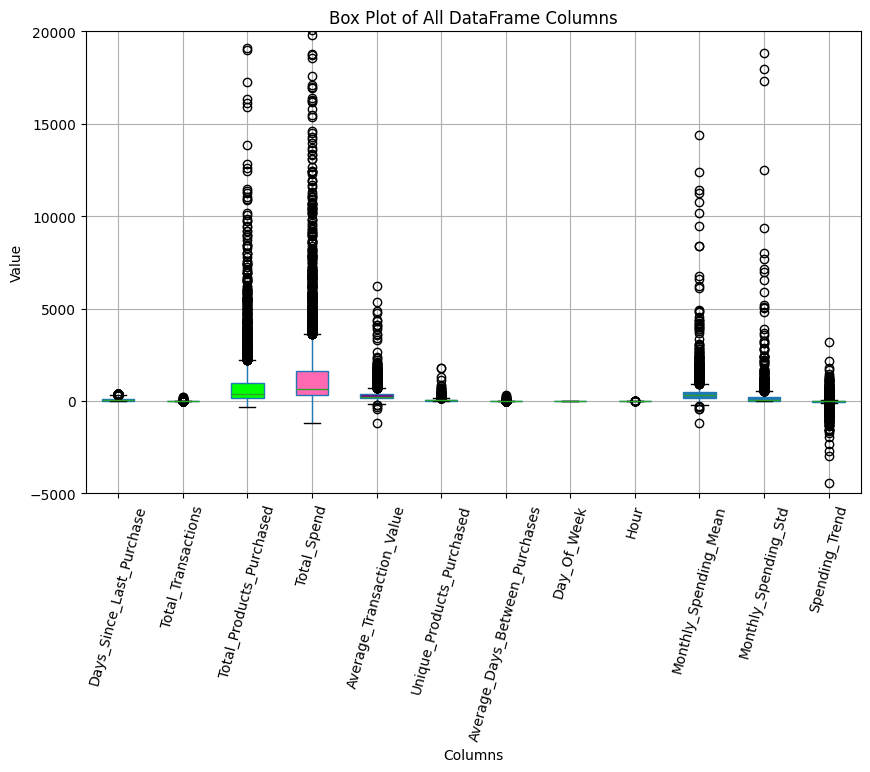

In [98]:
import matplotlib.pyplot as plt

# Define your y-axis range
y_min, y_max = -5000, 20000

plt.figure(figsize=(10, 6))
box = customer_data.boxplot(patch_artist=True, return_type='dict')

# Define a list of bright colors (add more if your dataframe has more columns)
colors = ['dodgerblue', 'orange', 'lime', 'hotpink', 'purple', 'gold', 'deepskyblue', 'magenta']

# Set a unique color for each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Tilt the x-axis labels at a 75-degree angle for readability
plt.xticks(rotation=75)

plt.ylim(y_min, y_max)
plt.title('Box Plot of All DataFrame Columns')
plt.ylabel('Value')
plt.xlabel('Columns')
plt.show()

In [99]:
from sklearn.ensemble import IsolationForest

# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,2,10,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,2,14,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2341,1797.24,449.31,22,9.433333,4,19,449.31,301.159918,-160.884,1,0
3,12349.0,18,1,631,1757.55,1757.55,73,0.0,1,9,1757.55,0.0,0.0,1,0
4,12350.0,310,1,197,334.4,334.4,17,0.0,3,16,334.4,0.0,0.0,1,0


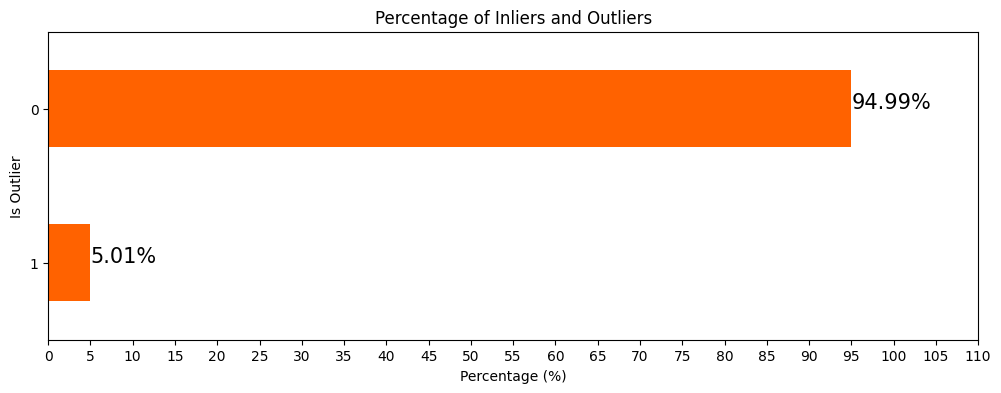

In [100]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [101]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [102]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4078

#### 10. Heatmap

In [103]:
# Compute the correlation matrix for numeric columns
corr_matrix = customer_data.select_dtypes(include='number').corr()

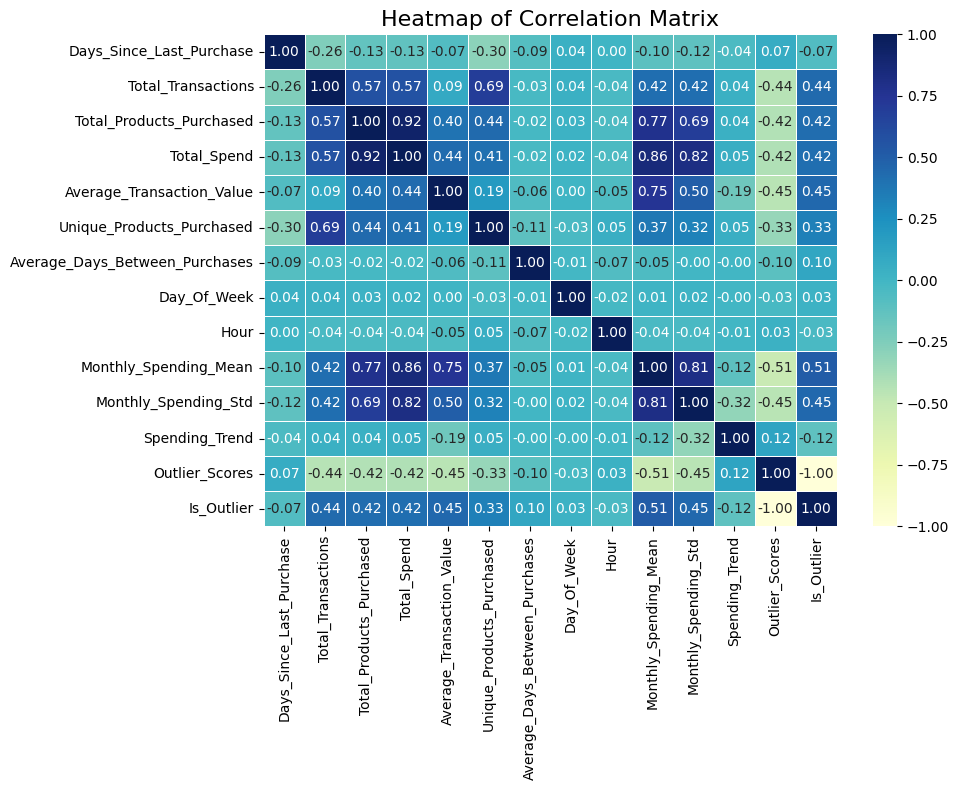

In [104]:
# Plotting Heatmap using
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, fmt='.2f')
plt.title('Heatmap of Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Clustering Methodology

#### 1. Feature Scaling

**Scaling using StandardScaler**

In [105]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.371925,-0.482987,-0.782592,-0.833273,-1.364112,-0.910316,-0.367017,2,-1.088163,-1.382401,-0.730288,0.081523
1,12347.0,-0.899852,0.614051,2.048680,2.333027,1.595716,0.783631,-0.132687,2,0.653923,1.018154,1.276883,0.110132
2,12348.0,-0.160410,-0.044172,1.913912,0.487052,0.795787,-0.561562,0.729152,4,2.831530,0.369375,1.042011,-0.944488
3,12349.0,-0.737783,-0.702395,-0.055769,0.457894,7.084688,0.285411,-0.367017,1,-1.523684,5.469958,-0.730288,0.081523
4,12350.0,2.219985,-0.702395,-0.555676,-0.587610,0.243397,-0.644599,-0.367017,3,1.524966,-0.078638,-0.730288,0.081523


#### 2. Dimensionality Reduction


- Multicollinearity Detected : In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.

- Better Clustering with K-means : Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.

- Noise Reduction : By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stable clusters.

- Enhanced Visualization: In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.

- Improved Computational Efficiency: Reducing the number of features can speed up the computation time during the modeling process, making our clustering algorithm more efficient.

**Which Dimensionality Reduction Method?**

In this step, we are considering the application of dimensionality reduction techniques to simplify our data while retaining the essential information. Among various methods such as KernelPCA, ICA, ISOMAP, TSNE, and UMAP, I am starting with PCA (Principal Component Analysis). Here's why:

PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

However, it's essential to note that we are keeping our options open. After applying PCA, if we find that the first few components do not capture a significant amount of variance, indicating a loss of vital information, we might consider exploring other non-linear methods. These methods can potentially provide a more nuanced approach to dimensionality reduction, capturing complex patterns that PCA might miss, albeit at the cost of increased computational time and complexity.

**Methodology**

I will apply PCA on all the available components and plot the cumulative variance explained by them. This process will allow me to visualize how much variance each additional principal component can explain, thereby helping me to pinpoint the optimal number of components to retain for the analysis:

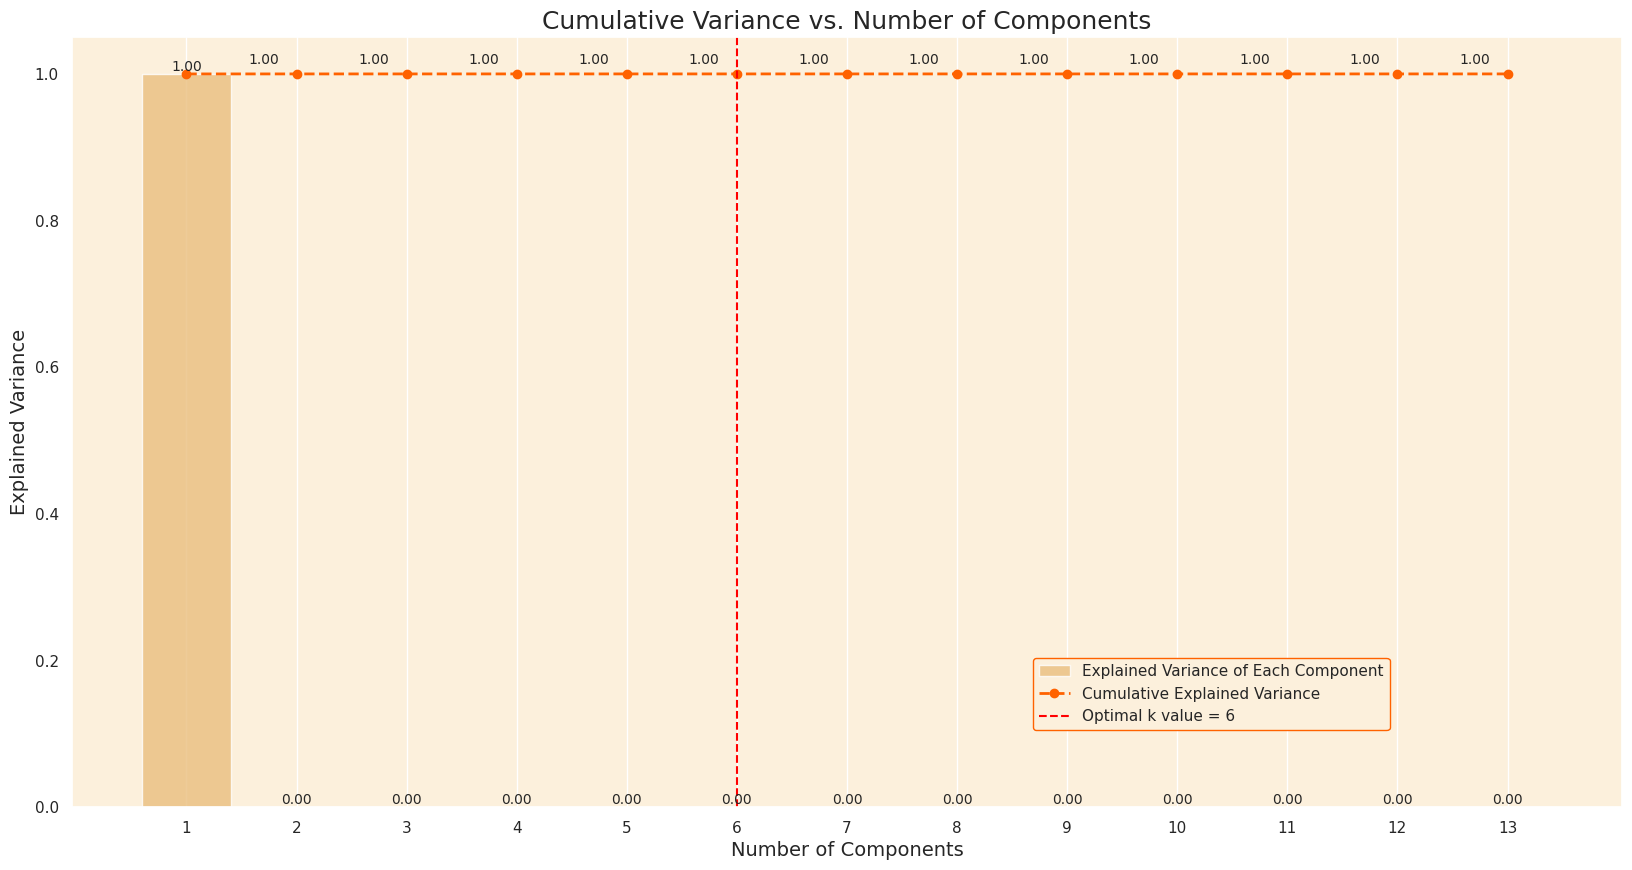

In [106]:
from sklearn.decomposition import PCA
from scipy.stats import linregress

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

**Conclusion**

The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

- The first component explains approximately 28% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 61% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [107]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [108]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2963.015184,-3.018525,-0.512182,-0.733309,-0.099182,-0.132148
1,-2962.015750,3.533870,-0.826639,0.466974,-0.265259,0.207097
2,-2961.015548,1.239632,1.296797,0.049860,-1.205483,-0.491178
3,-2960.016248,3.014094,-1.771270,7.522431,2.335225,0.214426
4,-2959.015311,-1.999668,0.406541,0.974276,-1.473747,0.384817


In [109]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #2d374b' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,1.000000,0.000084,0.000045,0.000072,0.000039,-0.000021
Days_Since_Last_Purchase,0.000004,-0.234020,0.056553,0.230863,-0.133523,-0.029848
Total_Transactions,-0.000007,0.371470,-0.001321,-0.378517,-0.072011,0.032408
Total_Products_Purchased,-0.000028,0.434618,0.003203,-0.086793,-0.002016,0.033160
Total_Spend,-0.000042,0.458836,0.001992,-0.067786,0.003145,0.019497
Average_Transaction_Value,-0.000070,0.223172,-0.002766,0.646039,0.148378,0.023946
Unique_Products_Purchased,0.000011,0.363343,-0.070786,-0.106562,-0.246421,0.064739
Average_Days_Between_Purchases,0.000019,-0.038595,0.004249,-0.259559,0.662151,0.037851
Day_Of_Week,-0.000043,0.035255,0.995111,-0.017686,-0.021360,0.042676
Hour,0.000047,-0.020286,-0.018175,0.000226,-0.651686,0.153476


#### 3. Determining Optimal Cluster



To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- Elbow Method

- Silhouette Method

It's common to utilize both methods in practice to corroborate the results.

**What is the Elbow Method?**

The Elbow Method is a technique for identifying the ideal number of clusters in a dataset. It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or **WCSS score**. By plotting the **inertia score** against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.

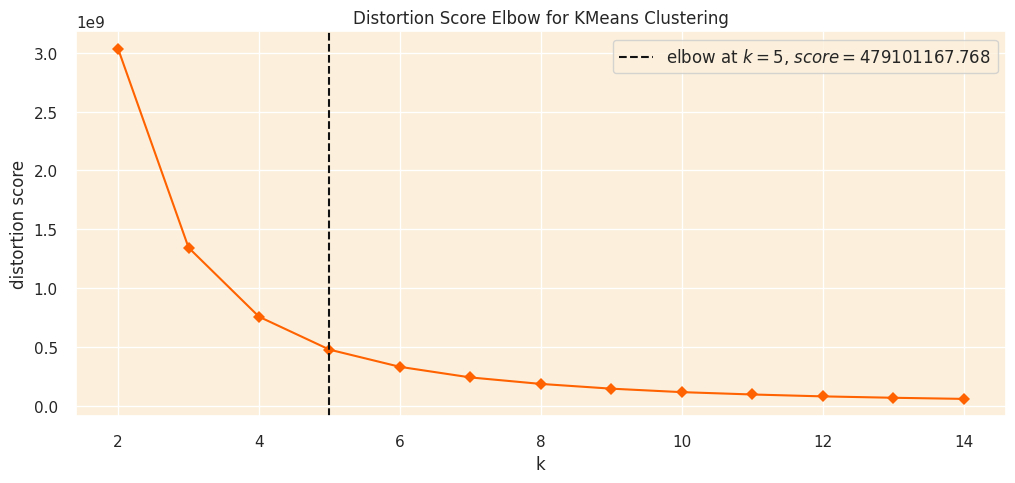

In [110]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

**Optimal k Value: Elbow Method Insights**

The optimal value of k for the KMeans clustering algorithm can be found at the elbow point. Using the YellowBrick library for the Elbow method, we observe that the suggested **optimal k value is 5**. However, we don't have a very distinct elbow point in this case, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that the optimum value of k could be between 3 and 7. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

**What is the Silhouette Method?**

The Silhouette Method is an approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.

**What are the Advantages of Silhouette Method over the Elbow Method?**

- The Silhouette Method evaluates cluster quality by considering both the cohesion within clusters and their separation from other clusters. This provides a more comprehensive measure of clustering performance compared to the Elbow Method, which only considers the inertia (sum of squared distances within clusters).

- The Silhouette Method produces a silhouette score that directly quantifies the quality of clustering, making it easier to compare different values of k. In contrast, the Elbow Method relies on the subjective interpretation of the elbow point, which can be less reliable in cases where the plot does not show a clear elbow.

- The Silhouette Method generates a visual representation of silhouette coefficients for each data point, allowing for easier identification of fluctuations and outliers within clusters. This helps in determining the optimal number of clusters with higher confidence, as opposed to the Elbow Method, which relies on visual inspection of the inertia plot.

In [111]:
import matplotlib.gridspec as gridspec
from yellowbrick.cluster import SilhouetteVisualizer

def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-886938352.py:64: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


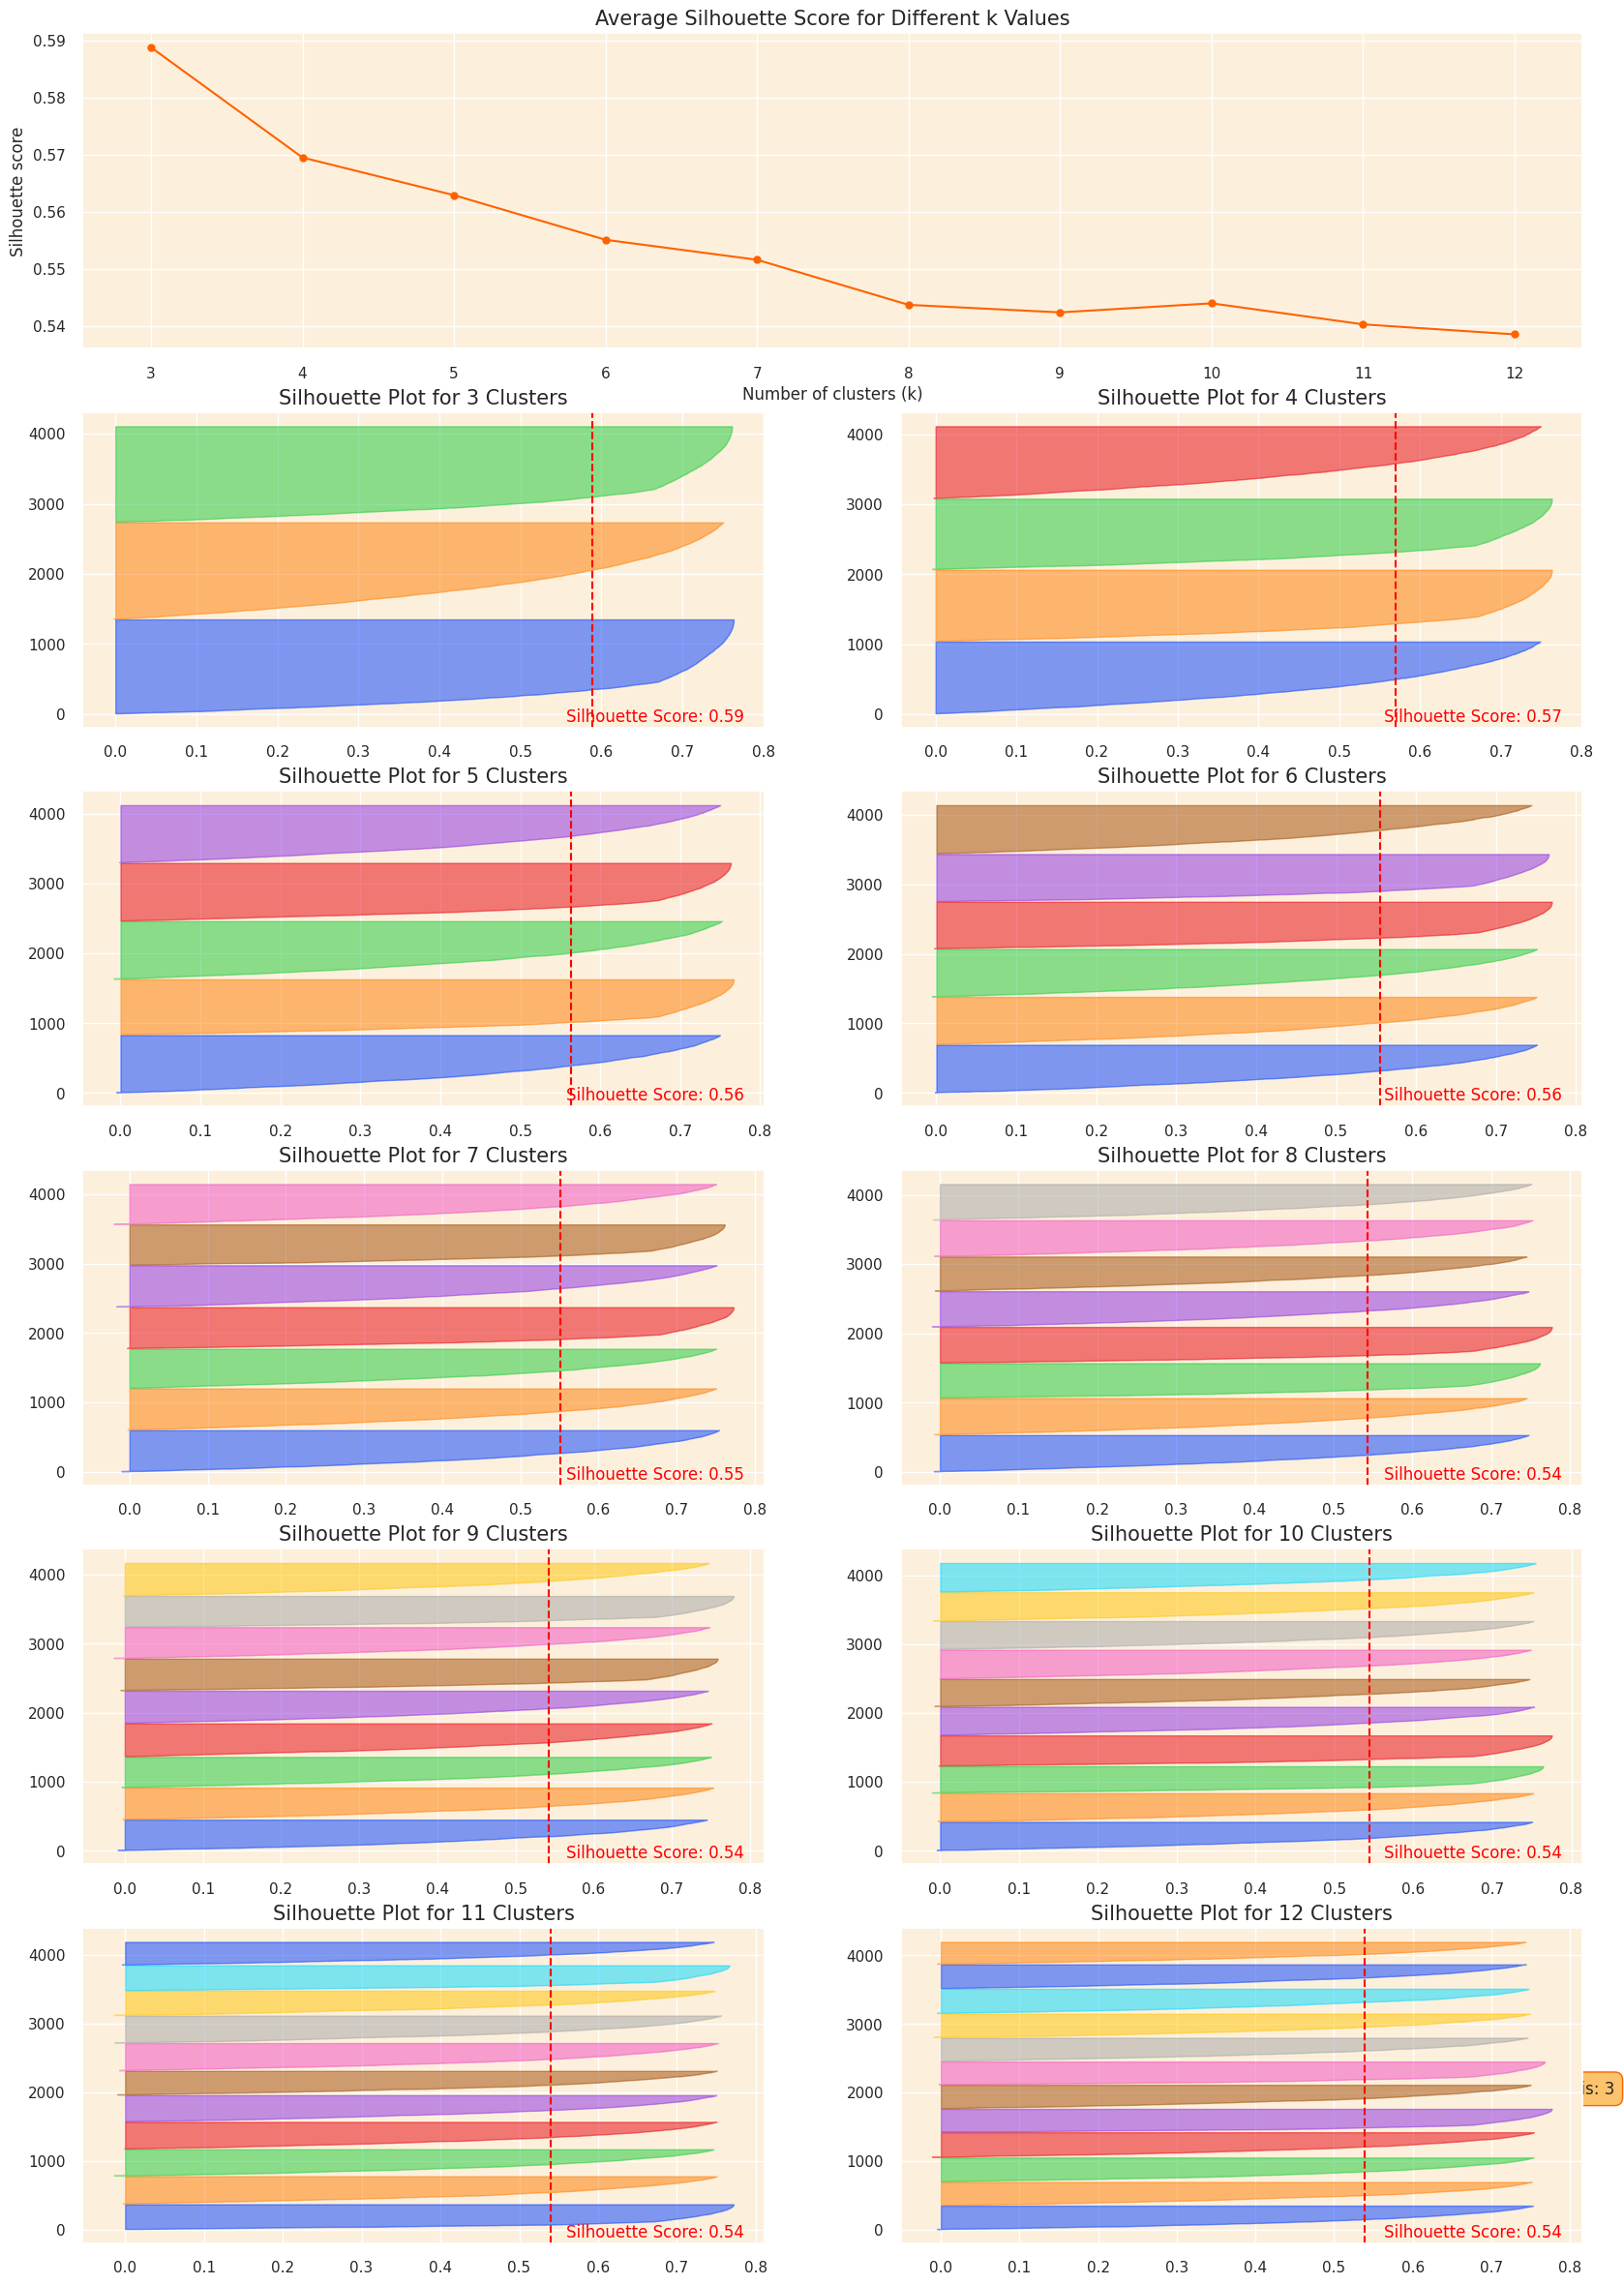

In [112]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

#### 4. K Means Clustering


**K-Means** is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the **within-cluster sum-of-squares (WCSS)**, also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

**Applying Model**

In [113]:
from collections import Counter
from sklearn.cluster import KMeans
import numpy as np

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=30, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [114]:
# Display the first few rows of the original dataframe
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,-2963.015184,-3.018525,-0.512182,-0.733309,-0.099182,-0.132148,2
1,-2962.015750,3.533870,-0.826639,0.466974,-0.265259,0.207097,2
2,-2961.015548,1.239632,1.296797,0.049860,-1.205483,-0.491178,2
3,-2960.016248,3.014094,-1.771270,7.522431,2.335225,0.214426,2
4,-2959.015311,-1.999668,0.406541,0.974276,-1.473747,0.384817,2


In [115]:
# Number of Data Points assigned to each Cluster
for i in customer_data_pca['cluster'].unique():
  print(f"Cluster {i} has {customer_data_pca[customer_data_pca['cluster'] == i].shape[0]} data points")

Cluster 2 has 1019 data points
Cluster 1 has 1030 data points
Cluster 0 has 1032 data points
Cluster 3 has 997 data points


**Saving the Model**

In [116]:
from google.colab import drive
import joblib
drive.mount('/content/drive')

# After saving the model as above, move or save directly to Drive:
joblib.dump(kmeans, '/content/drive/My Drive/kmeans_rfm_model.joblib')
print("Model saved to your Google Drive in 'My Drive'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to your Google Drive in 'My Drive'


#### 5. Visualization Clustering Results

**1. 3D - Plot**

In [117]:
import plotly.graph_objects as go

# Create separate data frames for each cluster (0 to 3)
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca['cluster'] == 3]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                          mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                          mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                          mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'],
                          mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

**2. Bar Plot**

/tmp/ipython-input-1531732811.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1531732811.py:8: UserWarning:

The palette list has more values (8) than needed (4), which may not be intended.



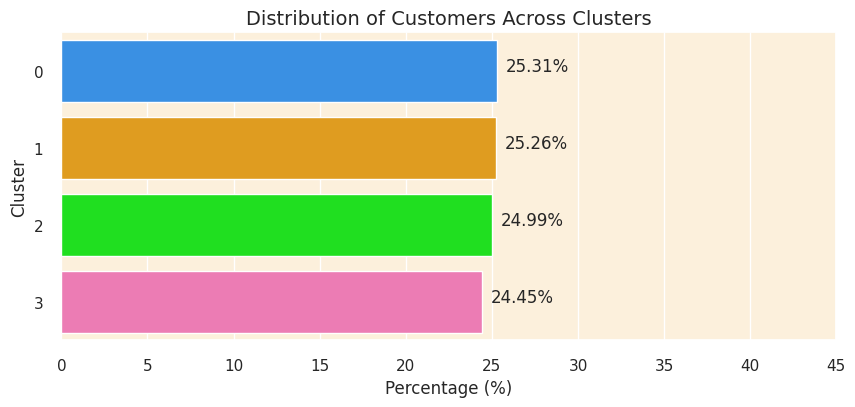

In [118]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

#### 6. Evaluating Metrics



To further scrutinize the quality of our clustering, I will employ the following metrics:

- *Silhouette Score* : A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.

- *Calinski Harabasz Score* : This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.

- *Davies Bouldin Score* : It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [119]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate

# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4078        |
|    Silhouette Score     | 0.5695635447518763 |
| Calinski Harabasz Score | 20115.63025874221  |
|  Davies Bouldin Score   | 0.501817586646513  |
+-------------------------+--------------------+


***Clustering Quality Inference***

The **Silhouette Score** of approximately 0.57, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

The **Calinski Harabasz Score** is 20115.4, which is high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

The **Davies Bouldin Score** of 0.501 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.

#### 7. Cluster Analysis and Customer Profiling

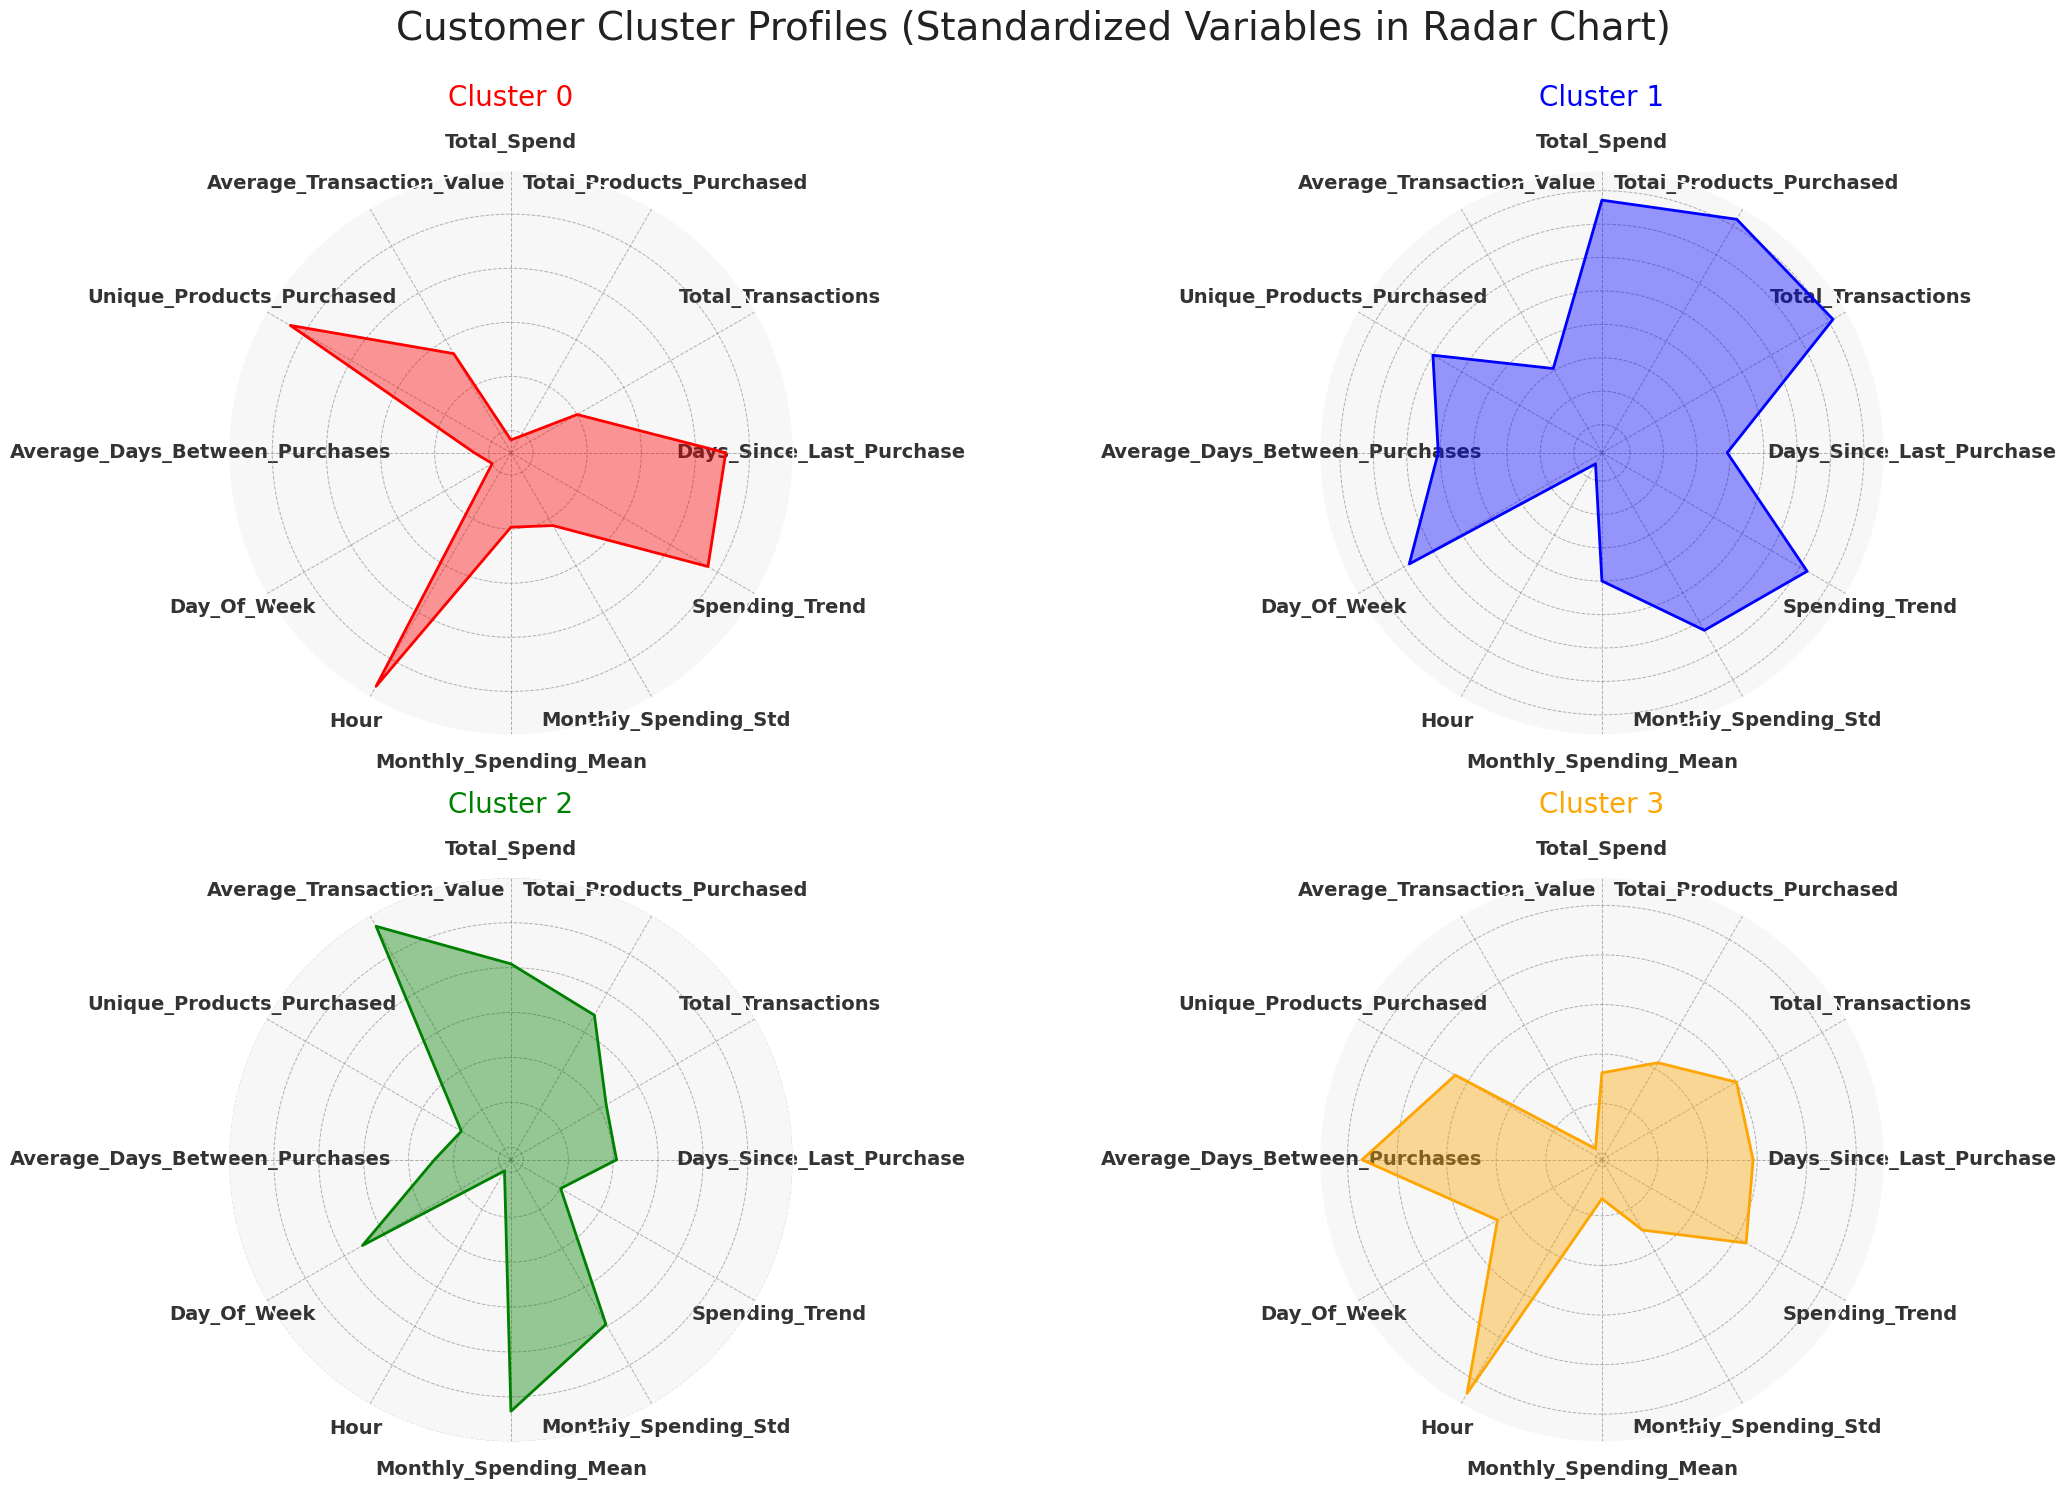

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Example color palette (adjust as needed)
colors = ['red', 'blue', 'green', 'orange']

# --- Data preparation steps remain unchanged ---
df_customer = customer_data_cleaned.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))
df_customer_standardized = pd.DataFrame(df_customer_standardized,
                                        columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)
    ax.grid(color='grey', linewidth=0.7, linestyle='--', alpha=0.6)
    ax.set_facecolor("#f7f7f7")  # Light background for improved contrast

labels = np.array(cluster_centroids.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# --- NEW: Set up a 2x2 grid for 4 clusters and a larger figure ---
fig, ax = plt.subplots(figsize=(22, 16), subplot_kw=dict(polar=True), nrows=2, ncols=2)

ax = ax.flatten()  # Make it easy to loop through all subplots

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1], fontsize=14, fontweight='bold', color="#333")
    ax[i].set_yticklabels([])  # Hide circular axis numbers for a cleaner look

# Optional: Add a main title
fig.suptitle("Customer Cluster Profiles (Standardized Variables in Radar Chart)", fontsize=28, color="#222", y=0.93)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.show()

**What does the 4 Charts shows?**

**Cluster 0 (Red) – High Value/Loyal Customers**

- Total Spend, Total Products Purchased, Total Transactions: Very high, meaning these customers are heavy buyers and highly engaged.

- Spending Trend, Monthly Spending Mean, Monthly Spending Std: Elevated, showing both consistently high spending and occasional surges.

- Days Since Last Purchase: Lower than average, so these customers purchase recently/frequently.

- Average Days Between Purchases: Also low, signaling very frequent transactions.

- Unique Products Purchased: Moderately high, indicating they buy many different things but not as diverse as some groups.

- Takeaway: This cluster represents your top-tier, highly active, and loyal customer base — very frequent and significant purchasers. They drive much of the business’s revenue.


**Cluster 1 (Blue) : – Diverse/Recent Lapsed Browsers**

- Unique Products Purchased: Extremely high, i.e., they explore and buy a broad variety.

- Total Spend, Total Transactions, Monthly Spending: Low, suggesting most are “window shoppers” or infrequent small buyers.

- Days Since Last Purchase: High, indicating they haven’t bought anything in a long time.

- Average Days Between Purchases: Moderate.

- Hour: Spikes here may indicate nonstandard shopping hours (night/odd times).

- Takeaway: These are diverse and curious shoppers who used to be active but have not purchased recently. They might be recaptured with targeted reactivation campaigns.



**Cluster 2 (Green) :– Diverse, Steady, Mid-Value Buyers**

- Average Transaction Value: Highest — these customers buy less frequently but make bigger purchases each time.

- Unique Products Purchased: Very high, i.e., they try new things often.

- Monthly Spending Std: Also high — some months they buy much more than others.

- Total Spend/Transactions: Medium.

- Spending Trend: Not very high, indicating steady habits.

- Takeaway: This group loves variety and makes occasional but high-value purchases. They’re important for upselling premium/new products and could be encouraged to purchase more often.

**Cluster 3 (Orange) – Low Engagement/Reactivated Segment**

- Average Days Between Purchases, Days Since Last Purchase: Both very high, showing long gaps between activity and possibly recent reactivation.

- Total Spend, Transactions, Products: Low.

- Hourly Activity: High, meaning their purchases may cluster at certain unusual hours.

- Monthly Spending, Spending Trend: Very low and stable.

- Takeaway: These are low-touch, infrequent customers (possibly new, lapsed, or just reactivated). They require engagement and nurturing to build frequency and value.

# 6. Recommendation System

In [144]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4 ─ identify the top-N best-selling products in each cluster
# ----------------------------------------------------------------
N = 10          # ← set this to any integer you like (e.g., 5, 15, …)

best_selling_products = (
    merged_data
        .groupby(['cluster', 'StockCode', 'Description'])['Quantity']
        .sum()
        .reset_index()
        .sort_values(['cluster', 'Quantity'], ascending=[True, False])
)

top_products_per_cluster = (
    best_selling_products
        .groupby('cluster')
        .head(N)        # keeps the top-N rows per cluster
)


# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top N products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_N_products_not_purchased = top_products_not_purchased.head(N) # Changed from .head(3) to .head(N)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_N_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# ──────────────────────────────────────────────────────────────
# Step 7 ─ create a dataframe that holds 10 product recommendations
#         (StockCode + Description) for every customer-cluster pair
# ──────────────────────────────────────────────────────────────

# Build the column list dynamically:  Rec1_StockCode, Rec1_Description, … Rec10_Description
cols = ['CustomerID', 'cluster']
for i in range(1, N + 1):        # N products ⇒ 2*N columns (code + description)
    cols += [f'Rec{i}_StockCode', f'Rec{i}_Description']

# Turn the `recommendations` list into a dataframe with those columns
recommendations_df = pd.DataFrame(recommendations, columns=cols)

# Merge with the cleaned customer table to attach the new columns
customer_data_with_recommendations = (
    customer_data_cleaned
        .merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')
)

In [152]:
# Display 20 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -20:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description,Rec4_StockCode,Rec4_Description,Rec5_StockCode,Rec5_Description,Rec6_StockCode,Rec6_Description,Rec7_StockCode,Rec7_Description,Rec8_StockCode,Rec8_Description,Rec9_StockCode,Rec9_Description,Rec10_StockCode,Rec10_Description
CustomerID,,,,,,,,,,,,,,,,,,,,
17349.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22151,PLACE SETTING WHITE HEART,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,84946,ANTIQUE SILVER T-LIGHT GLASS
18252.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22151,PLACE SETTING WHITE HEART,85099B,JUMBO BAG RED RETROSPOT,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,84946,ANTIQUE SILVER T-LIGHT GLASS,None,None,None,None
14789.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,85123A,WHITE HANGING HEART T-LIGHT HOLDER,85099B,JUMBO BAG RED RETROSPOT,16014,SMALL CHINESE STYLE SCISSOR,21212,PACK OF 72 RETROSPOT CAKE CASES,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,22616,PACK OF 12 LONDON TISSUES
15157.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,85123A,WHITE HANGING HEART T-LIGHT HOLDER,85099B,JUMBO BAG RED RETROSPOT,16014,SMALL CHINESE STYLE SCISSOR,21212,PACK OF 72 RETROSPOT CAKE CASES,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,22616,PACK OF 12 LONDON TISSUES
13168.0,84568,GIRLS ALPHABET IRON ON PATCHES,85099B,JUMBO BAG RED RETROSPOT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15036,ASSORTED COLOURS SILK FAN,21212,PACK OF 72 RETROSPOT CAKE CASES,22178,VICTORIAN GLASS HANGING T-LIGHT,22492,MINI PAINT SET VINTAGE,23084,RABBIT NIGHT LIGHT,84879,ASSORTED COLOUR BIRD ORNAMENT,21731,RED TOADSTOOL LED NIGHT LIGHT
18022.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22151,PLACE SETTING WHITE HEART,22616,PACK OF 12 LONDON TISSUES,22178,VICTORIAN GLASS HANGING T-LIGHT,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,84946,ANTIQUE SILVER T-LIGHT GLASS,None,None,None,None,None,None
13634.0,84568,GIRLS ALPHABET IRON ON PATCHES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15036,ASSORTED COLOURS SILK FAN,21212,PACK OF 72 RETROSPOT CAKE CASES,22492,MINI PAINT SET VINTAGE,23084,RABBIT NIGHT LIGHT,21731,RED TOADSTOOL LED NIGHT LIGHT,None,None,None,None,None,None
17535.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22151,PLACE SETTING WHITE HEART,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,84946,ANTIQUE SILVER T-LIGHT GLASS,None,None
18085.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22151,PLACE SETTING WHITE HEART,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,22178,VICTORIAN GLASS HANGING T-LIGHT,17003,BROCADE RING PURSE,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,84946,ANTIQUE SILVER T-LIGHT GLASS


In [153]:
from google.colab import files
customer_data_with_recommendations.to_csv("customer_data_with_recommendations.csv", index = True)
files.download("customer_data_with_recommendations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>